Import Libraries and Setup

In [11]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


Web Scraping Functions

In [12]:
def scrape_forbes_2019_data():
    """Scrape the 2019 Forbes Global 2000 table specifically"""
    url = "https://en.wikipedia.org/wiki/List_of_largest_companies_in_Canada"

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the 2019 Forbes section
        forbes_section = None
        headings = soup.find_all(['h2', 'h3'])

        for heading in headings:
            if '2019' in heading.get_text() and 'Forbes' in heading.get_text():
                forbes_section = heading
                break

        if not forbes_section:
            print("Looking for Forbes Global 2000 table...")
            # Alternative approach: find table with Forbes-related content
            tables = soup.find_all('table', class_='wikitable')

            for table in tables:
                # Check if table contains Forbes-related data
                table_text = table.get_text()
                if 'Forbes' in table_text or 'Global 2000' in table_text:
                    forbes_table = table
                    break
            else:
                # If no Forbes table found, use the first major table
                forbes_table = tables[0] if tables else None
        else:
            # Find the table after the Forbes heading
            forbes_table = forbes_section.find_next('table', class_='wikitable')

        if not forbes_table:
            print("No suitable table found. Using first available table.")
            forbes_table = soup.find('table', class_='wikitable')

        return extract_table_data(forbes_table)

    except Exception as e:
        print(f"Error scraping data: {e}")
        return []

def extract_table_data(table):
    """Extract data from the Forbes table"""
    if not table:
        return []

    # Get headers
    headers = []
    header_row = table.find('tr')
    if header_row:
        for th in header_row.find_all(['th', 'td']):
            header_text = th.get_text().strip()
            header_text = re.sub(r'\[.*?\]', '', header_text)  # Remove citations
            headers.append(header_text)

    print(f"Table headers: {headers}")

    # Extract data rows
    companies_data = []
    rows = table.find_all('tr')[1:]  # Skip header

    for row in rows:
        cells = row.find_all(['td', 'th'])
        if len(cells) >= len(headers):
            row_data = {}
            for i, header in enumerate(headers):
                if i < len(cells):
                    cell_text = cells[i].get_text().strip()
                    # Clean the text
                    cell_text = re.sub(r'\[.*?\]', '', cell_text)  # Remove citations
                    cell_text = re.sub(r'\s+', ' ', cell_text)     # Clean whitespace
                    row_data[header] = cell_text
                else:
                    row_data[header] = ''
            companies_data.append(row_data)

    return companies_data

# Scrape the data
print("🔍 Scraping 2019 Forbes data from Wikipedia...")
raw_data = scrape_forbes_2019_data()
print(f"✅ Scraped {len(raw_data)} companies")

🔍 Scraping 2019 Forbes data from Wikipedia...
Table headers: ['Rank', 'Forbes 2000 rank', 'Name', 'Headquarters', 'Revenue(billions US$)', 'Profit(billions US$)', 'Assets(billions US$)', 'Value(billions US$)', 'Industry']
✅ Scraped 56 companies


Data Cleaning and Preprocessing

In [13]:
def clean_forbes_data(raw_data):
    """Clean and preprocess the Forbes data for EDA"""
    if not raw_data:
        print("No data to clean")
        return pd.DataFrame()

    df = pd.DataFrame(raw_data)
    print(f"Original shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # Display first few rows to understand structure
    print("\nFirst 3 rows of raw data:")
    print(df.head(3))

    # Clean column names
    df.columns = df.columns.str.strip()

    # Function to clean monetary values
    def clean_monetary_value(value):
        if pd.isna(value) or value == '':
            return np.nan
        # Remove currency symbols, commas, and extract numbers
        cleaned = re.sub(r'[^\d.]', '', str(value))
        try:
            return float(cleaned) if cleaned else np.nan
        except:
            return np.nan

    # Function to clean numeric values
    def clean_numeric_value(value):
        if pd.isna(value) or value == '':
            return np.nan
        # Extract numeric part
        cleaned = re.sub(r'[^\d.]', '', str(value))
        try:
            return float(cleaned) if cleaned else np.nan
        except:
            return np.nan

    # Identify and clean numeric columns
    numeric_keywords = ['revenue', 'sales', 'profit', 'assets', 'value', 'market', 'rank']

    for col in df.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in numeric_keywords):
            if 'rank' in col_lower:
                df[col] = df[col].apply(clean_numeric_value)
            else:
                df[col] = df[col].apply(clean_monetary_value)

    # Clean company names
    if 'Company' in df.columns:
        df['Company'] = df['Company'].str.strip()
    elif 'Name' in df.columns:
        df['Company'] = df['Name'].str.strip()

    # Clean industry/sector
    industry_cols = [col for col in df.columns if 'industry' in col.lower() or 'sector' in col.lower()]
    for col in industry_cols:
        df[col] = df[col].str.strip()

    print(f"\nCleaned shape: {df.shape}")
    return df

# Clean the data
df = clean_forbes_data(raw_data)

Original shape: (56, 9)
Columns: ['Rank', 'Forbes 2000 rank', 'Name', 'Headquarters', 'Revenue(billions US$)', 'Profit(billions US$)', 'Assets(billions US$)', 'Value(billions US$)', 'Industry']

First 3 rows of raw data:
  Rank Forbes 2000 rank                   Name Headquarters  \
0    1               41   Royal Bank of Canada     Montreal   
1    2               46  Toronto-Dominion Bank      Toronto   
2    3               87             Scotiabank      Toronto   

  Revenue(billions US$) Profit(billions US$) Assets(billions US$)  \
0                  46.3                  9.6              1,040.3   
1                  42.5                  8.7              1,007.0   
2                  32.4                  6.4                787.5   

  Value(billions US$) Industry  
0               114.9  Banking  
1               103.8  Banking  
2                67.1  Banking  

Cleaned shape: (56, 10)


Initial Data Overview

In [14]:
def data_overview(df):
    """Provide comprehensive overview of the dataset"""
    print("📊 DATA OVERVIEW")
    print("=" * 50)

    print(f"Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")

    print("\n📋 Column Information:")
    print(df.info())

    print("\n🔍 Data Types:")
    for col in df.columns:
        print(f"  {col}: {df[col].dtype}")

    print("\n❓ Missing Values:")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing Count': missing.values,
        'Missing %': missing_percent.values
    })
    print(missing_df[missing_df['Missing Count'] > 0])

    print("\n📈 Sample Data:")
    print(df.head())

    return df

# Display overview
df = data_overview(df)

📊 DATA OVERVIEW
Dataset shape: 56 rows × 10 columns
Memory usage: 17.90 KB

📋 Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rank                   56 non-null     float64
 1   Forbes 2000 rank       56 non-null     float64
 2   Name                   56 non-null     object 
 3   Headquarters           56 non-null     object 
 4   Revenue(billions US$)  56 non-null     float64
 5   Profit(billions US$)   56 non-null     float64
 6   Assets(billions US$)   56 non-null     float64
 7   Value(billions US$)    56 non-null     float64
 8   Industry               56 non-null     object 
 9   Company                56 non-null     object 
dtypes: float64(6), object(4)
memory usage: 4.5+ KB
None

🔍 Data Types:
  Rank: float64
  Forbes 2000 rank: float64
  Name: object
  Headquarters: object
  Revenue(billions US

EDA - Descriptive Statistics

In [15]:
def descriptive_statistics(df):
    """Generate descriptive statistics"""
    print("📊 DESCRIPTIVE STATISTICS")
    print("=" * 50)

    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) > 0:
        print("Numeric columns summary:")
        print(df[numeric_cols].describe())

        # Additional statistics
        print("\n📈 Additional Statistics:")
        for col in numeric_cols:
            if df[col].notna().sum() > 0:
                print(f"\n{col}:")
                print(f"  Range: {df[col].min():.2f} - {df[col].max():.2f}")
                print(f"  IQR: {df[col].quantile(0.75) - df[col].quantile(0.25):.2f}")
                print(f"  Skewness: {df[col].skew():.2f}")
                print(f"  Kurtosis: {df[col].kurtosis():.2f}")

    # Categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    if len(categorical_cols) > 0:
        print(f"\n📝 Categorical Columns ({len(categorical_cols)}):")
        for col in categorical_cols:
            unique_count = df[col].nunique()
            print(f"  {col}: {unique_count} unique values")
            if unique_count <= 10:
                print(f"    Values: {df[col].value_counts().head().to_dict()}")

descriptive_statistics(df)

📊 DESCRIPTIVE STATISTICS
Numeric columns summary:
            Rank  Forbes 2000 rank  Revenue(billions US$)  \
count  56.000000         56.000000              56.000000   
mean   28.500000        911.821429              16.166071   
std    16.309506        575.502029              14.478502   
min     1.000000         41.000000               0.500000   
25%    14.750000        382.000000               5.500000   
50%    28.500000        935.500000              10.850000   
75%    42.250000       1323.000000              21.000000   
max    56.000000       1978.000000              59.700000   

       Profit(billions US$)  Assets(billions US$)  Value(billions US$)  
count             56.000000             56.000000            56.000000  
mean               1.796429            119.278571            25.071429  
std                1.982832            237.720952            23.724262  
min                0.000000              1.800000             0.800000  
25%                0.500000        

EDA - Visualizations

📊 CREATING VISUALIZATIONS


<Figure size 1500x1000 with 0 Axes>

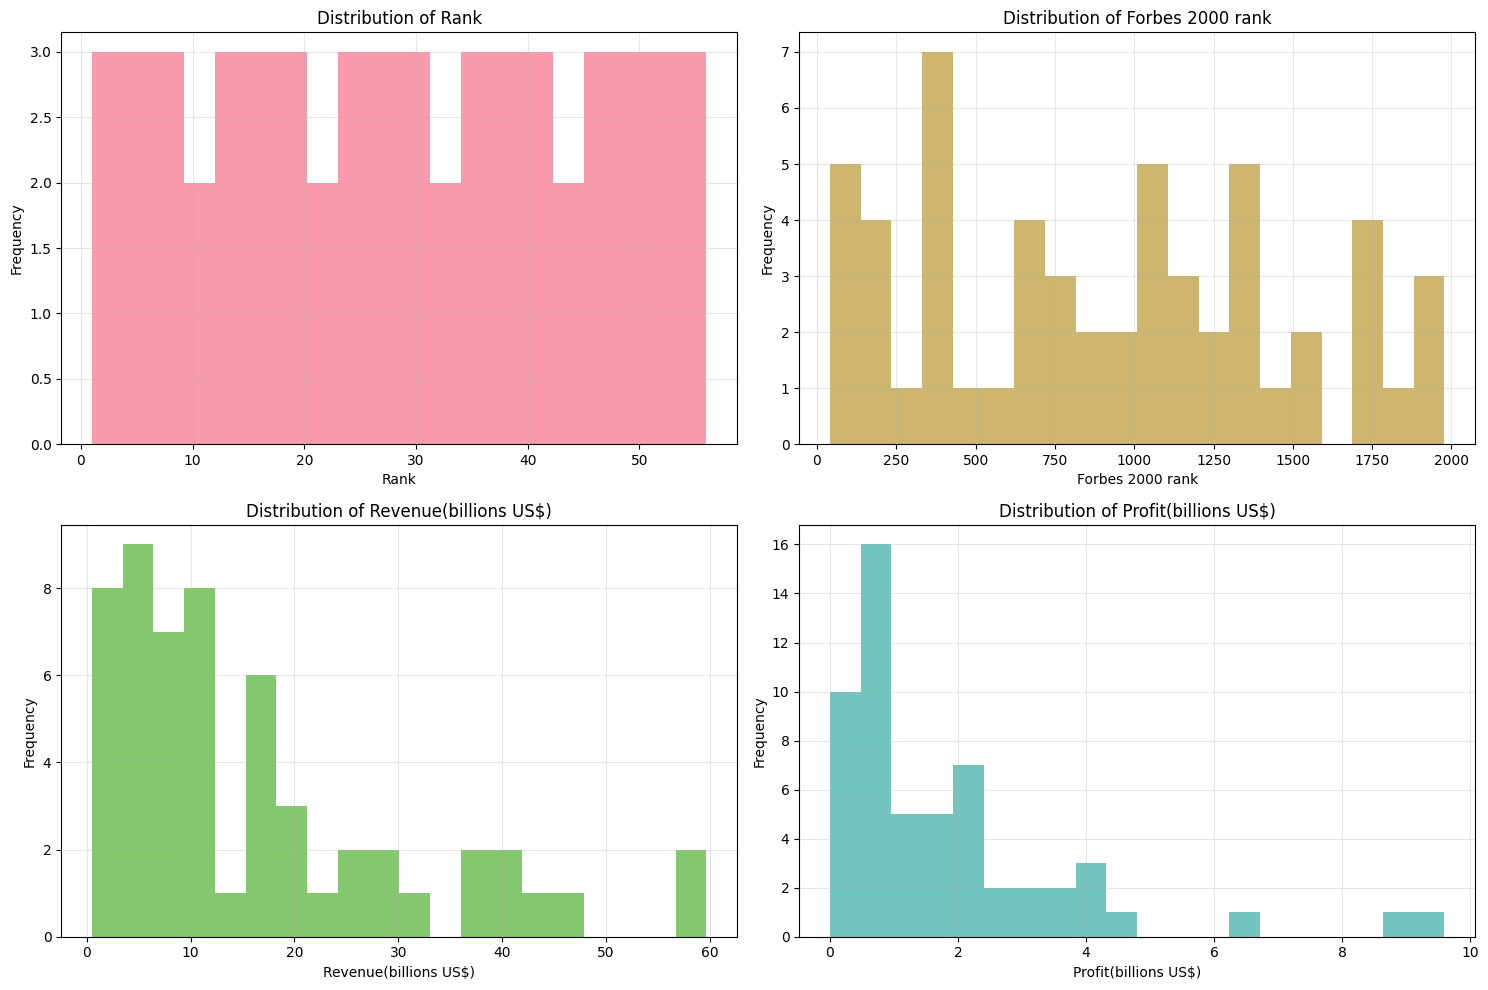

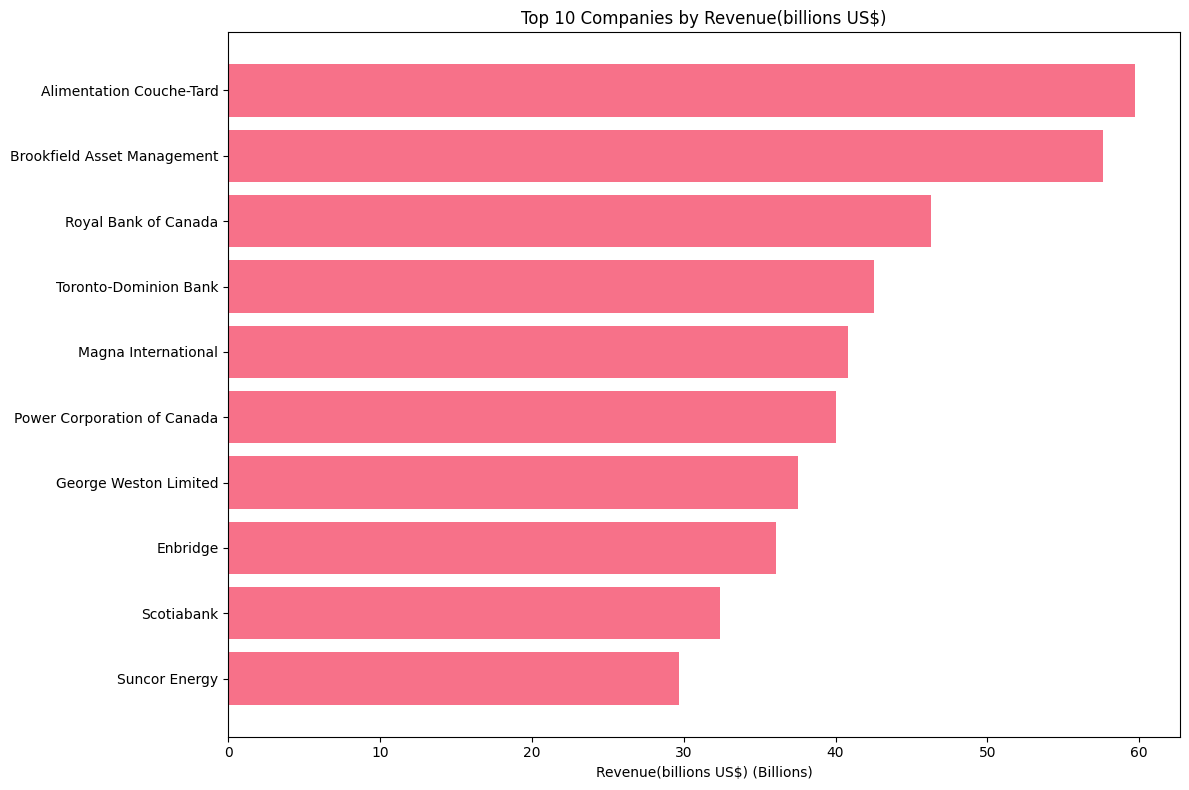

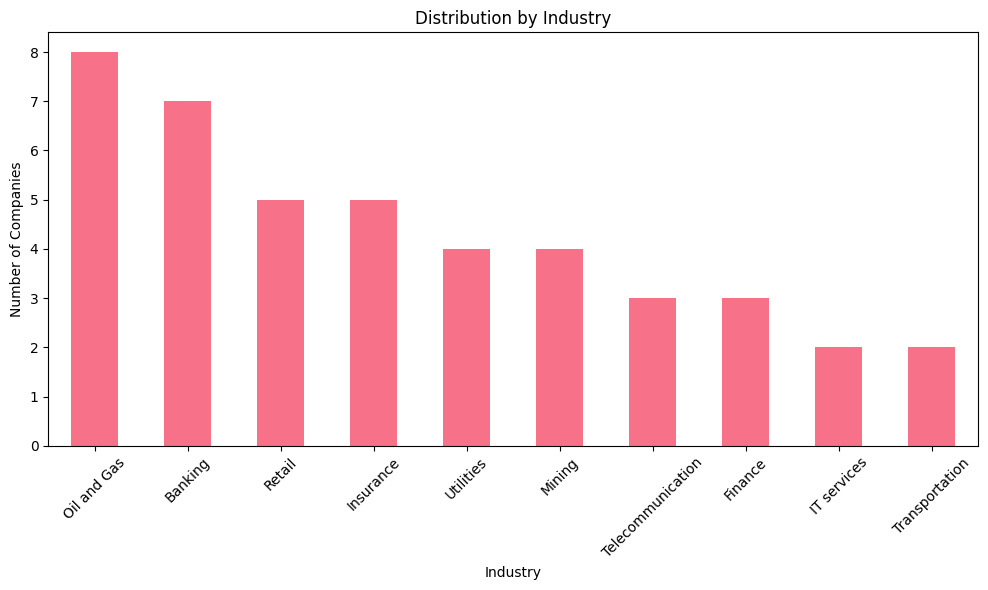

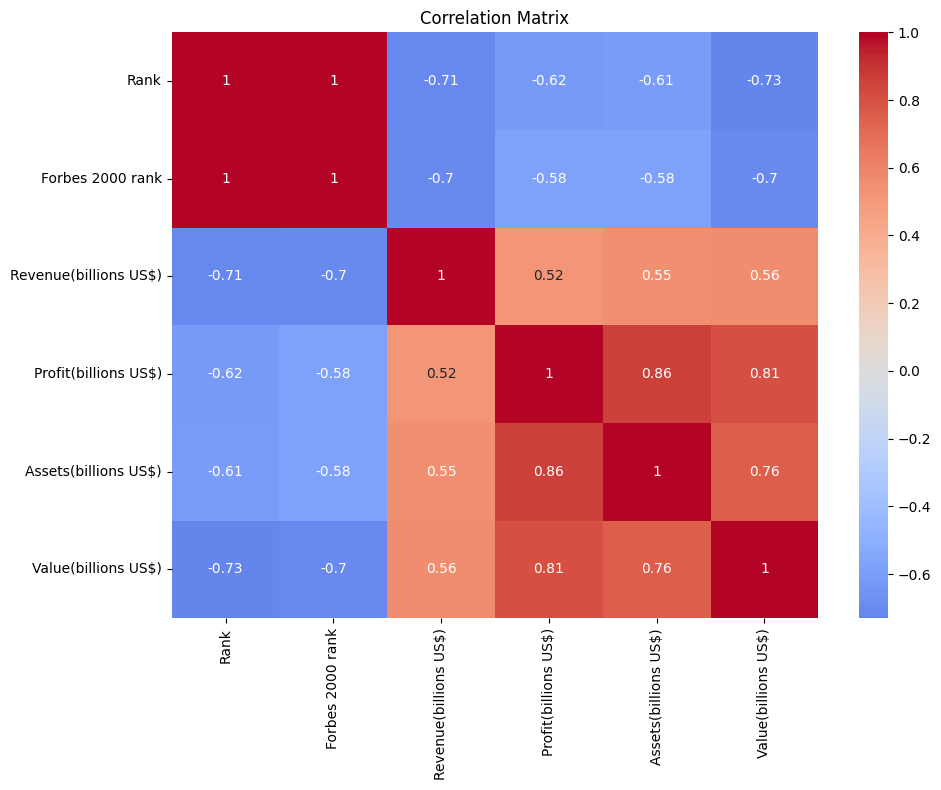

In [16]:
def create_visualizations(df):
    """Create comprehensive visualizations"""
    print("📊 CREATING VISUALIZATIONS")
    print("=" * 50)

    # Set up the plotting area
    plt.figure(figsize=(15, 10))

    # Get numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) == 0:
        print("No numeric columns found for visualization")
        return

    # 1. Distribution plots
    n_numeric = len(numeric_cols)
    if n_numeric > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()

        for i, col in enumerate(numeric_cols[:4]):  # Show first 4 numeric columns
            if i < 4:
                ax = axes[i]
                data = df[col].dropna()
                if len(data) > 0:
                    ax.hist(data, bins=20, alpha=0.7, color=f'C{i}')
                    ax.set_title(f'Distribution of {col}')
                    ax.set_xlabel(col)
                    ax.set_ylabel('Frequency')
                    ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # 2. Top companies by revenue (if revenue column exists)
    revenue_cols = [col for col in df.columns if 'revenue' in col.lower() or 'sales' in col.lower()]
    if revenue_cols and 'Company' in df.columns:
        revenue_col = revenue_cols[0]
        top_companies = df.nlargest(10, revenue_col)

        plt.figure(figsize=(12, 8))
        plt.barh(top_companies['Company'], top_companies[revenue_col])
        plt.title(f'Top 10 Companies by {revenue_col}')
        plt.xlabel(f'{revenue_col} (Billions)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    # 3. Industry distribution (if industry column exists)
    industry_cols = [col for col in df.columns if 'industry' in col.lower() or 'sector' in col.lower()]
    if industry_cols:
        industry_col = industry_cols[0]
        industry_counts = df[industry_col].value_counts().head(10)

        plt.figure(figsize=(10, 6))
        industry_counts.plot(kind='bar')
        plt.title(f'Distribution by {industry_col}')
        plt.xlabel(industry_col)
        plt.ylabel('Number of Companies')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 4. Correlation matrix
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = df[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()

create_visualizations(df)

Advanced EDA - Interactive Visualizations

In [17]:
def create_interactive_plots(df):
    """Create interactive visualizations using Plotly"""
    print("📊 INTERACTIVE VISUALIZATIONS")
    print("=" * 50)

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) == 0:
        print("No numeric columns for interactive plots")
        return

    # 1. Interactive scatter plot
    if len(numeric_cols) >= 2:
        fig = px.scatter(df,
                        x=numeric_cols[0],
                        y=numeric_cols[1],
                        hover_data=['Company'] if 'Company' in df.columns else None,
                        title=f'{numeric_cols[0]} vs {numeric_cols[1]}')
        fig.show()

    # 2. Interactive bar chart for top companies
    revenue_cols = [col for col in df.columns if 'revenue' in col.lower() or 'sales' in col.lower()]
    if revenue_cols and 'Company' in df.columns:
        revenue_col = revenue_cols[0]
        top_companies = df.nlargest(10, revenue_col)

        fig = px.bar(top_companies,
                    x='Company',
                    y=revenue_col,
                    title=f'Top 10 Companies by {revenue_col}')
        fig.update_layout(xaxis_tickangle=-45)
        fig.show()

    # 3. Interactive pie chart for industries
    industry_cols = [col for col in df.columns if 'industry' in col.lower() or 'sector' in col.lower()]
    if industry_cols:
        industry_col = industry_cols[0]
        industry_counts = df[industry_col].value_counts().head(8)

        fig = px.pie(values=industry_counts.values,
                    names=industry_counts.index,
                    title=f'Distribution by {industry_col}')
        fig.show()

create_interactive_plots(df)

📊 INTERACTIVE VISUALIZATIONS


Key insights and Analysis

In [18]:
def generate_insights(df):
    """Generate key insights from the data"""
    print("🔍 KEY INSIGHTS")
    print("=" * 50)

    insights = []

    # Basic insights
    insights.append(f"📊 Dataset contains {len(df)} Canadian companies from 2019 Forbes list")

    # Revenue insights
    revenue_cols = [col for col in df.columns if 'revenue' in col.lower() or 'sales' in col.lower()]
    if revenue_cols:
        revenue_col = revenue_cols[0]
        revenue_data = df[revenue_col].dropna()
        if len(revenue_data) > 0:
            insights.append(f"💰 Revenue range: ${revenue_data.min():.1f}B - ${revenue_data.max():.1f}B")
            insights.append(f"💰 Average revenue: ${revenue_data.mean():.1f}B")
            insights.append(f"💰 Median revenue: ${revenue_data.median():.1f}B")

    # Industry insights
    industry_cols = [col for col in df.columns if 'industry' in col.lower() or 'sector' in col.lower()]
    if industry_cols:
        industry_col = industry_cols[0]
        top_industry = df[industry_col].value_counts().head(1)
        if len(top_industry) > 0:
            insights.append(f"🏭 Most common industry: {top_industry.index[0]} ({top_industry.values[0]} companies)")

    # Top company
    if revenue_cols and 'Company' in df.columns:
        top_company = df.loc[df[revenue_cols[0]].idxmax()]
        insights.append(f"🏆 Largest company by revenue: {top_company['Company']} (${top_company[revenue_cols[0]]:.1f}B)")

    # Data quality insights
    completeness = (df.notna().sum() / len(df) * 100).mean()
    insights.append(f"📈 Data completeness: {completeness:.1f}%")

    # Print insights
    for insight in insights:
        print(insight)

    return insights

insights = generate_insights(df)

🔍 KEY INSIGHTS
📊 Dataset contains 56 Canadian companies from 2019 Forbes list
💰 Revenue range: $0.5B - $59.7B
💰 Average revenue: $16.2B
💰 Median revenue: $10.9B
🏭 Most common industry: Oil and Gas (8 companies)
🏆 Largest company by revenue: Alimentation Couche-Tard ($59.7B)
📈 Data completeness: 100.0%


Export and Final Summary

In [19]:
def export_results(df, insights):
    """Export the cleaned data and analysis results"""
    print("💾 EXPORTING RESULTS")
    print("=" * 50)

    # Save cleaned data
    df.to_csv('forbes_2019_canada_companies.csv', index=False)
    df.to_excel('forbes_2019_canada_companies.xlsx', index=False)

    # Save insights
    with open('eda_insights.txt', 'w') as f:
        f.write("2019 Forbes Canada Companies - EDA Insights\n")
        f.write("=" * 50 + "\n\n")
        for insight in insights:
            f.write(insight + "\n")

    print("✅ Files exported:")
    print("  - forbes_2019_canada_companies.csv")
    print("  - forbes_2019_canada_companies.xlsx")
    print("  - eda_insights.txt")

    # Final summary
    print(f"\n🎉 EDA COMPLETE!")
    print(f"✅ Analyzed {len(df)} companies")
    print(f"✅ Generated {len(insights)} insights")
    print(f"✅ Created multiple visualizations")
    print(f"✅ Data ready for further analysis")

export_results(df, insights)

💾 EXPORTING RESULTS
✅ Files exported:
  - forbes_2019_canada_companies.csv
  - forbes_2019_canada_companies.xlsx
  - eda_insights.txt

🎉 EDA COMPLETE!
✅ Analyzed 56 companies
✅ Generated 7 insights
✅ Created multiple visualizations
✅ Data ready for further analysis


Display Final Dataset

In [23]:
from IPython.display import display, HTML

# Section Title
display(HTML("<h2>📋 FINAL DATASET</h2><hr>"))

# Shape
print(f"🔢 Shape: {df.shape}")

# First 10 Rows with Gradient
display(HTML("<h4>First 10 Rows (with Highlights):</h4>"))
display(
    df.head(10)
      .style.format(precision=2)
      .background_gradient(subset=[
          'Revenue(billions US$)',
          'Profit(billions US$)',
          'Assets(billions US$)',
          'Value(billions US$)'
      ], cmap='YlGnBu')
      .set_table_attributes('style="width:100%;border-collapse:collapse;"')
)

# Column Info Summary
display(HTML("<h4>📊 Column Information:</h4>"))
column_info = pd.DataFrame({
    "Column": df.columns,
    "Non-null Count": df.notnull().sum().values,
    "Total": len(df),
    "Percent Non-null": (df.notnull().sum().values / len(df) * 100).round(1)
})

display(
    column_info.style
        .format(precision=1)
        .background_gradient(cmap='Greens')
        .set_table_attributes('style="width:70%;border-collapse:collapse;"')
)

🔢 Shape: (56, 10)


,Rank,Forbes 2000 rank,Name,Headquarters,Revenue(billions US$),Profit(billions US$),Assets(billions US$),Value(billions US$),Industry,Company
0,1.00,41.00,Royal Bank of Canada,Montreal,46.30,9.60,1040.30,114.90,Banking,Royal Bank of Canada
1,2.00,46.00,Toronto-Dominion Bank,Toronto,42.50,8.70,1007.00,103.80,Banking,Toronto-Dominion Bank
2,3.00,87.00,Scotiabank,Toronto,32.40,6.40,787.50,67.10,Banking,Scotiabank
3,4.00,118.00,Brookfield Asset Management,Toronto,57.60,3.60,256.30,46.00,Finance,Brookfield Asset Management
4,5.00,134.00,Bank of Montreal,Montreal,26.20,4.60,614.20,50.40,Banking,Bank of Montreal
5,6.00,166.00,Manulife,Toronto,28.40,3.70,517.80,36.20,Insurance,Manulife
6,7.00,174.00,Enbridge,Calgary,36.10,2.20,122.20,75.30,Oil and Gas,Enbridge
7,8.00,190.00,Canadian Imperial Bank of Commerce,Toronto,20.20,3.90,486.00,36.80,Banking,Canadian Imperial Bank of Commerce
8,9.00,229.00,Suncor Energy,Calgary,29.70,2.50,65.60,52.60,Oil and Gas,Suncor Energy
9,10.00,273.00,Sun Life Financial,Toronto,23.40,2.00,196.00,24.50,Insurance,Sun Life Financial


,Column,Non-null Count,Total,Percent Non-null
0,Rank,56,56,100.0
1,Forbes 2000 rank,56,56,100.0
2,Name,56,56,100.0
3,Headquarters,56,56,100.0
4,Revenue(billions US$),56,56,100.0
5,Profit(billions US$),56,56,100.0
6,Assets(billions US$),56,56,100.0
7,Value(billions US$),56,56,100.0
8,Industry,56,56,100.0
9,Company,56,56,100.0
